# SCoT -  Source Connectivity Toolbox
SCoT is a Python package for EEG/MEG source connectivity estimation. Source connectivity means that cortical sources are estimated from surface EEG or MEG signals, and then connectivity between these sources is computed. This makes a lot of sense especially in the case of EEG, where EEG channels are in general highly correlated. This means that the actual sources of activity on the cortex can not be easily inferred from EEG channel activity, but sophisticated source identification techniques (such as ICA) must be used.

## Prerequisites
SCoT runs on Python 2 and 3. I strongly recommend that you use Python 3 unless you have a very good reason not to. You can install any Python distribution you like, but if you are a beginner, I suggest that you try [Anaconda Python](https://www.continuum.io/downloads). This distribution is really easy to install and comes with lots of useful preinstalled Python packages. Download and install the appropriate installer package for your platform and you are good to go.

## Obtaining SCoT
SCoT can be installed just like any other Python package using `pip`. In a terminal, type the following command to install the latest release of the package:

    pip install scot

The current development version might contain bug fixes and/or new features not present in the latest release version, but it might also be unstable. If you want to use this bleeding edge version, clone the git repository using the following command in a terminal:

    git clone https://github.com/scot-dev/scot.git

Note that if you want to use the development version, you need to manually add it to the Python module search path. You can do this by either setting the environment variable `PYTHONPATH` to the folder where you cloned the package, or you can append this folder directly in Python using `sys.path.append("path/to/scot")`. In this tutorial, we'll be using this method to install SCoT, because the way the example data can be obtained has been dramatically simplified over previous versions.

## Other packages
SCoT depends on NumPy and SciPy, so these packages should have already been pulled in during SCoT installation. Since you probably want to create connectivity plots, you need to install `matplotlib` (using `pip` - if you are using Anaconda you already have `matplotlib` installed). Other optional packages that SCoT uses if they are installed are `scikit-learn` and `mne`. Feel free to install them as well, but we will only use `matplotlib` in this tutorial.

## Example data
We will use an example EEG data set available in SCoT to demonstrate some of the functionality provided by the toolbox. 45 EEG channels were recorded from a person performing a motor imagery task (i.e. the person imagined moving a hand or a foot). The data was preprocessed to reduce eye movement artifacts and resampled to 100 Hz. With a visual cue, the person was instructed to perform either hand or foot motor imagery for approximately six seconds.

## Data analysis
OK, so we're all set. Let's start with importing the toolbox.

In [2]:
import scot

Next, let's load the example data set that comes with SCoT. By default, the data set will be downloaded to a folder called `scot_data` within your home folder.

In [3]:
data = scot.exampledata.load("mi")[0]

For convenience, we'll assign separate names to the various objects contained in the example data.

In [4]:
raweeg = data["eeg"]
triggers = data["triggers"]
fs = data["fs"]
labels = data["labels"]
locs = data["locations"]

Since the EEG signals are continuous, we need to extract epochs by cutting out segments around the trigger time points. We'll create one second epochs starting 3 seconds and ending 4 seconds after the triggers.

In [85]:
epochs = scot.datatools.cut_segments(raweeg, triggers, 3 * fs, 4 * fs)

SCoT offers an object-oriented API based on a workspace. This is probably the most user-friendly way to use the toolbox, but it doesn't offer the full range of possible functions. We'll be using this approach since it is the most convenient way to perform basic analysis. With the following command, we create a workspace and set some parameters to appropriate values. In particular, we set the VAR model order to 40, we tell it to reduce the dimensionality from 45 channels to 4 components. Furthermore, we declare the sampling rate of the EEG recording as well as the electrode locations.

In [114]:
ws = scot.Workspace({'model_order': 40}, reducedim=4, fs=fs, locations=locs)

We still need to tell the workspace object which data it should use.

In [115]:
ws.set_data(epochs, labels)

Now we are ready to fit a VAR model and perform ICA to recover cortical sources. We will use the supervised variant CSPVARICA, which requires class labels for all epochs. CSPVARICA creates a spatial filter that maximizes the difference between two classes. The resulting components are then reduced to the specified number, and a VAR model is fit on these components. Finally, ICA is performed on the VAR model residuals to estimate the effect of volume conduction and to recover cortical sources.

In [116]:
ws.do_cspvarica()

We can check if the fitted VAR model is a good fit to the data by checking if the residuals are white. The return value of this function is the p-value of the hypothesis test that the residuals are white.

In [117]:
ws.var_.test_whiteness(50)

0.73999999999999999

Since this p-value is much larger than e.g. 0.05, we cannot reject the null hypothesis and we can therefore assume that the model is a good fit to the data. If this test was significant, we would have to go back and fit a new model with e.g. a higher model order.

We are now ready to visualize the results of the previous computations. First, we set up the usual matplotlib-related stuff and set a larger figure size.

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 10]

## Connectivity plot
The first figure we are going to create will show connectivity from each source to each remaining source. Therefore, the plot will be organized as a matrix, where columns correspond to sources of information flow and rows correspond to sinks of information flow. The diagonal of this matrix is therefore not useful, and we will use it to plot the power spectrum of the corresponding source instead. We specify the frequency range to plot, declare what we want to plot on the diagonal and tell SCoT that we want scalp topographies of the sources along the borders of the figure.

In [119]:
ws.plot_f_range = [0, 35]
ws.plot_diagonal = 'S'
ws.plot_outside_topo = True

Now we first create a figure with the scalp topographies along the top and left borders of the figure. Then, we fit a new VAR model to the epochs corresponding to the foot labels only. From this task-specific VAR model, we extract a connectivity measure (in this example, we'll use the square of the partial directed coherence, or short sPDC). We plot the resulting connectivity estimates into the same plot we've populated with scalp topos before. We repeat this step for the hand imagery data and plot the result into the same plot. This way, we end up with a nice connectivity plot that visualizes the sPDC over frequency for each task (blue corresponds to foot whereas green corresponds to hand).

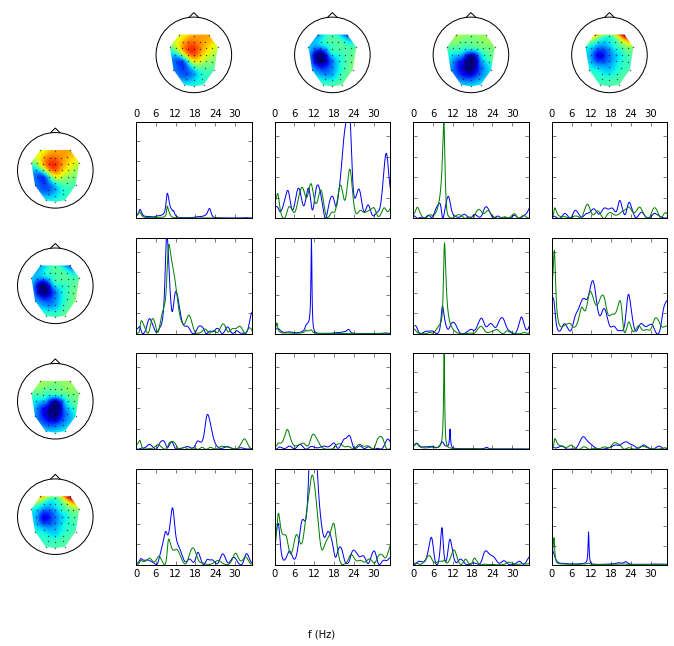

In [120]:
fig = ws.plot_connectivity_topos()

ws.set_used_labels(['foot'])
ws.fit_var()
_ = ws.get_connectivity('sPDC', fig)

ws.set_used_labels(['hand'])
ws.fit_var()
_ = ws.get_connectivity('sPDC', fig)

## Circular plot
The next figure we are going to create visualizes the connectivity between sources in a different way. Specifically, we are going to average over the alpha frequency range and use arrows to indicate significant connectivity (i.e. that exceeds a certain threshold). Let's create a new workspace and tell it to keep 15 components:

In [121]:
ws = scot.Workspace({'model_order': 30}, reducedim=15, fs=fs, locations=locs)

In [122]:
ws.set_data(epochs, labels)

In [123]:
ws.do_cspvarica()

In [124]:
ws.var_.test_whiteness(50)

1.0

In [127]:
import numpy as np

freq = np.linspace(0, fs, ws.nfft_)
alpha = {}
for label in np.unique(labels):
    ws.set_used_labels([label])
    ws.fit_var()
    con = ws.get_connectivity('sPDC')
    alpha[label] = np.mean(con[:, :, np.logical_and(8 < freq, freq < 12)], axis=2)
    np.fill_diagonal(alpha[label], 0)  # force diagonal connectivity to zero

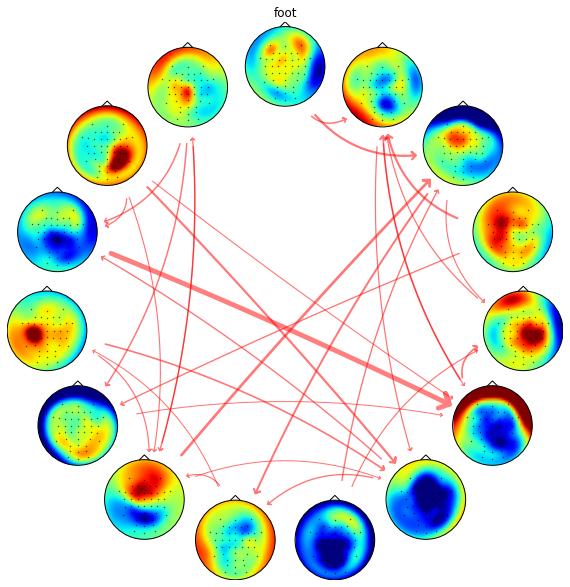

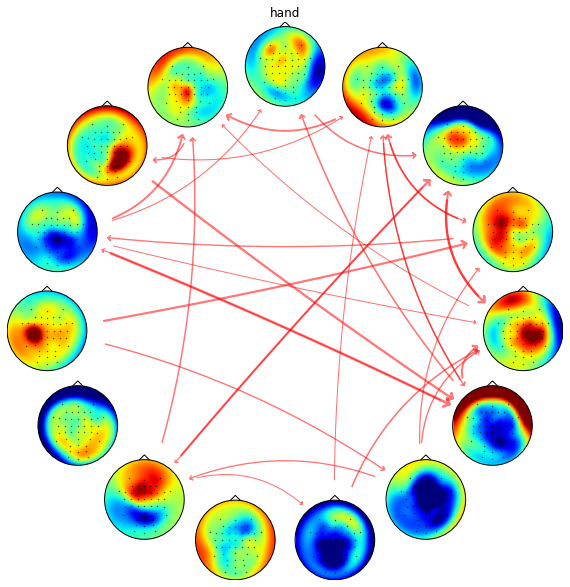

In [156]:
topo = scot.eegtopo.topoplot.Topoplot()
topo.set_locations(locs)
mixmaps = scot.plotting.prepare_topoplots(topo, ws.mixing_)

th = 1  # manually set threshold

order = None
for label in np.unique(labels):
    w = alpha[label] * 50  # arrow width
    m = w > th  # mask all connections below th
    
    if not order:
        order = scot.utils.cuthill_mckee(m)

    # fixed color, but width and transparency varies with connectivity strength
    r = np.ones(w.shape)
    g = np.zeros(w.shape)
    b = np.zeros(w.shape)
    a = (alpha[label]-th) / max(np.max(alpha['hand']-th), np.max(alpha['foot']-th))
    a /= 2
    c = np.dstack([r, g, b, a])

    scot.plotting.plot_circular(colors=c, widths=w, mask=m, topo=topo,
                                topomaps=mixmaps, order=order)
    plt.title(label)

## Time-frequency plot
We can also examine the evolution of connectivity over time. That is, we can look at how connectivity changes around the trigger depending on the task.

In [196]:
ws = scot.Workspace({'model_order': 40}, reducedim=4, fs=fs, locations=locs)

In [197]:
epochs = scot.datatools.cut_segments(raweeg, triggers, 3 * fs, 4 * fs)

In [198]:
ws.set_data(epochs, labels)

In [199]:
ws.do_cspvarica()

In [200]:
ws.var_.test_whiteness(50)

0.81999999999999995

In [201]:
epochs = scot.datatools.cut_segments(raweeg, triggers, -2 * fs, 8 * fs)

In [202]:
ws.plot_f_range = [0, 30]  # only show 0-30 Hz
ws.plot_diagonal = 'topo'  # put topo plots on the diagonal
ws.plot_outside_topo = False  # no topo plots above and to the left

In [203]:
ws.set_data(epochs, labels, time_offset=-2.5)

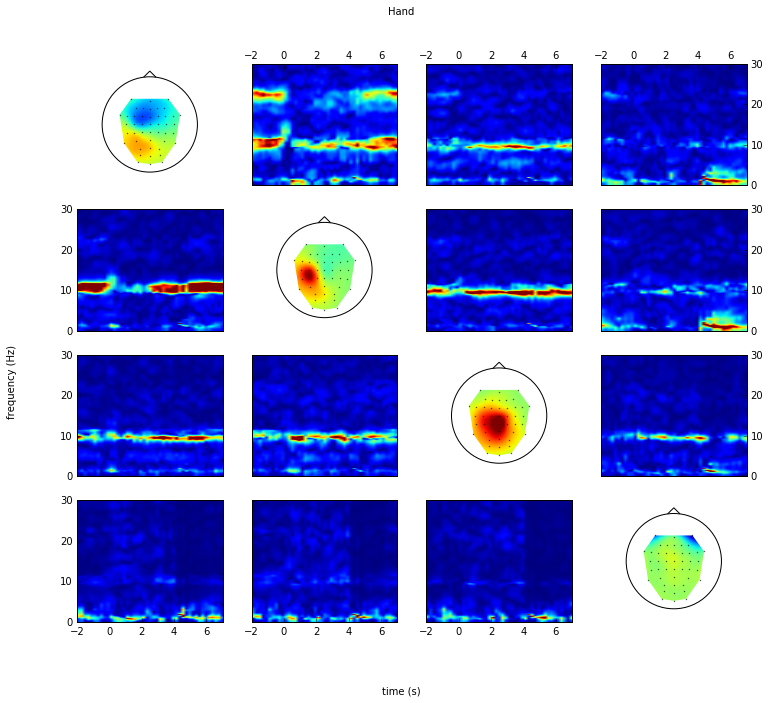

In [204]:
fig = ws.plot_connectivity_topos()
ws.set_used_labels(['hand'])
ws.get_tf_connectivity('ffDTF', 1 * fs, int(0.2 * fs), plot=fig,
                       crange=[0, 30])
fig.suptitle('Hand')

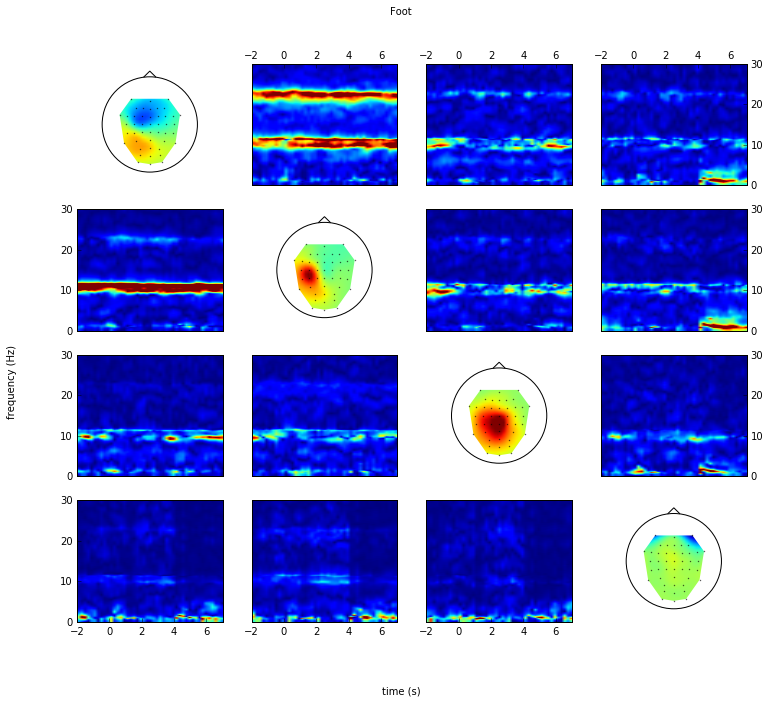

In [205]:
fig = ws.plot_connectivity_topos()
ws.set_used_labels(['foot'])
ws.get_tf_connectivity('ffDTF', 1 * fs, int(0.2 * fs), plot=fig,
                       crange=[0, 30])
fig.suptitle('Foot')